In [1]:
import PyMieScatt as ps

In [2]:
import meep as mp

In [3]:
import numpy as np

In [4]:
from typing import List, Tuple, Dict

In [5]:
from matplotlib import pyplot as plt

In [6]:
from copy import deepcopy

In [7]:
sphere_radius : float = 1.0

In [8]:
wavelength_bounds : Tuple[float, float] = (
        2 * np.pi * sphere_radius / 10.0, 
        2 * np.pi * sphere_radius / 2.0
    )

In [9]:
minimum_frequency : float = 1.0 / max(wavelength_bounds)

In [10]:
maximum_frequency : float = 1.0 / min(wavelength_bounds)

In [11]:
center_frequency : float = (maximum_frequency + minimum_frequency) / 2.0

In [12]:
frequency_width : float = maximum_frequency - minimum_frequency

In [13]:
frequency_count : int = 100

In [14]:
perfectly_matched_layer_thickness : float = max(wavelength_bounds) / 2.0

In [15]:
air_thickness : float = max(wavelength_bounds) / 2.0

In [16]:
boundary_layers : List[mp.PML] = [mp.PML(thickness = perfectly_matched_layer_thickness)]

In [17]:
symmetries : List[mp.Mirror] = [mp.Mirror(mp.Y), mp.Mirror(mp.Z, phase = -1)]

In [18]:
uniform_cell_size : int = int(2.0 * ( \
        perfectly_matched_layer_thickness \
        + air_thickness \
        + sphere_radius
    ))

In [19]:
cell_size : mp.Vector3 = mp.Vector3(uniform_cell_size, uniform_cell_size, uniform_cell_size)

In [20]:
sphere_index_of_refraction : float = 2.0

In [21]:
sources : List[mp.Source] = [mp.Source(
        mp.GaussianSource(center_frequency, fwidth = frequency_width, is_integrated = True), 
        center = mp.Vector3(-.5 * uniform_cell_size + perfectly_matched_layer_thickness), 
        size = mp.Vector3(0, uniform_cell_size, uniform_cell_size), 
        component = mp.Ez
    )]

In [22]:
resolution : int = 25

In [23]:
# https://stackoverflow.com/questions/2150108/efficient-way-to-rotate-a-list-in-python
def rotate_list(to_rotate : List, by): 
    return to_rotate[by:] + to_rotate[:by]

In [24]:
def generate_mirrored_flux_regions(
            offsets : Tuple[float, float], 
            size_vector : List[mp.Vector3], 
            axes : List[str] = ['x', 'y', 'z']
        ) -> List[mp.FluxRegion]: 
    flux_regions : List[mp.FluxRegion] = []
    for axis in axes: 
        for offset in offsets: 
            flux_regions.append(mp.FluxRegion(
                    center = mp.Vector3(**{axis : offset}), 
                    size = mp.Vector3(
                            size_vector[0], 
                            size_vector[1], 
                            size_vector[2]
                        )
                ))
        size_vector = rotate_list(size_vector, -1)
    return flux_regions


In [25]:
flux_regions : List[mp.FluxRegion] = generate_mirrored_flux_regions(
        [-sphere_radius, sphere_radius], 
        [0, 2 * sphere_radius, 2 * sphere_radius]
    )

In [26]:
def run_control_variable_geometry_simulation(
            resolution : float, 
            frequency_bounds : Tuple[float, float], 
            frequency_count : int, 
            flux_regions : List[mp.FluxRegion], 
            boundary_layers : List[mp.PML], 
            sources : List[mp.Source], 
            cell_size : mp.Vector3, 
            symmetries : List[mp.Mirror], 
            variable_geometry : List[mp.GeometricObject], 
            k_point : mp.Vector3 = mp.Vector3(), 
            run_time_after_sourecs : int = 10
        ):
    geometries : List[List[mp.GeometricObject]] = [None, variable_geometry]
    simulator_fluxes : List[List[mp.simulation.DftFlux]] = []
    simulation_flux_data : List[List[mp.simulation.FluxData]] = []
    simulation_result_fluxes : List[List[np.array]] = []
    frequency_center : float = (max(frequency_bounds) + min(frequency_bounds)) / 2.0
    frequency_width : float = (max(frequency_bounds) - min(frequency_bounds))
    flux_frequencies : List[np.array] = []
    for current_geometry in geometries: 
        print(current_geometry)
        #simulator = None
        #if current_geometry == None: 
        #print("A")
        print("-----------NEW SIMULATION-----------")
        simulator : mp.Simulation = mp.Simulation(
                resolution = resolution, 
                cell_size = cell_size, 
                boundary_layers = boundary_layers, 
                sources = sources, 
                k_point = k_point, 
                symmetries = symmetries, 
                geometry = current_geometry
            )
        #else: 
        #    print("B")
        #    simulator : mp.Simulation = mp.Simulation(
        #            resolution = resolution, 
        #            cell_size = cell_size, 
        #            boundary_layers = boundary_layers, 
        #            sources = sources, 
        #            k_point = k_point, 
        #            symmetries = symmetries
        #        )
        simulator_fluxes.append([])
        for flux_index, flux_region in enumerate(flux_regions): 
            simulator_fluxes[-1].append(simulator.add_flux(
                    frequency_center, 
                    frequency_width, 
                    frequency_count, 
                    deepcopy(flux_region)
                ))
            if current_geometry != None and len(simulation_flux_data) == 1: 
                print("SUBTRACTING FLUX DATA")
                simulator.load_minus_flux_data(
                        simulator_fluxes[-1][flux_index], 
                        simulation_flux_data[0][flux_index]
                    )
        simulator.run(until_after_sources = run_time_after_sourecs)
        sample_flux : mp.simulation.DftFlux = simulator_fluxes[-1][0]
        flux_frequencies.append(mp.get_flux_freqs(sample_flux))
        simulation_flux_data.append([])
        simulation_result_fluxes.append([])
        for flux in simulator_fluxes[-1]: 
            simulation_flux_data[-1].append(simulator.get_flux_data(flux))
            simulation_result_fluxes[-1].append(mp.get_fluxes(flux))
        simulator.reset_meep()
    return simulation_flux_data, simulation_result_fluxes, flux_frequencies, simulator_fluxes

In [27]:
def odd_negative(index : int): 
    return 1 if index % 2 == 0 else -1

In [28]:
def theoretical_flux_predict(
            input_fluxes : List[mp.simulation.DftFlux], 
            sphere_radius : float, 
            sphere_index_of_refraction : float, 
            control_result_flux : np.array, 
            scale_factor : float, 
            frequency_domain : np.array
        ) -> np.array: 
    scattered_flux : float = np.asarray([
            odd_negative(flux_index) * np.asarray(flux) \
            for flux_index, flux in enumerate(input_fluxes)
        ])
    control_intensity : np.array = np.asarray(control_result_flux) / (2.0 * sphere_radius) ** 2
    scattered_cross_section = scattered_flux / control_intensity
    scattered_effect_meep : np.array = -scattered_cross_section / (np.pi * sphere_radius ** 2)
    scattered_effect_thoery : np.array = np.asarray([
            ps.MieQ(
                    sphere_index_of_refraction, 
                    scale_factor / frequency, 
                    2 * sphere_radius * scale_factor, 
                    asDict = True
                )['Qsca'] \
            for frequency in frequency_domain
        ])
    return scattered_effect_meep, scattered_effect_thoery 

In [29]:
flux_data, result_fluxes, flux_frequencies, input_fluxes = run_control_variable_geometry_simulation(
            resolution, 
            (maximum_frequency, minimum_frequency), 
            frequency_count, 
            flux_regions, 
            boundary_layers, 
            sources, 
            cell_size, 
            symmetries, 
            [mp.Sphere(
                    material = mp.Medium(index = sphere_index_of_refraction), 
                    center = mp.Vector3(), 
                    radius = sphere_radius
                )]
    )

None
-----------NEW SIMULATION-----------
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00151205 s
Working in 3D dimensions.
Computational cell is 8 x 8 x 8 with resolution 25
time for set_epsilon = 3.09877 s
-----------


FloatProgress(value=0.0, description='0% done ', max=17.853981494903564)

Meep progress: 0.22/17.853981494903564 = 1.2% done in 4.0s, 320.8s to go
on time step 12 (time=0.24), 0.338852 s/step
Meep progress: 1.3/17.853981494903564 = 7.3% done in 8.1s, 102.9s to go
on time step 65 (time=1.3), 0.075618 s/step
Meep progress: 2.22/17.853981494903564 = 12.4% done in 12.1s, 85.6s to go
on time step 111 (time=2.22), 0.0884591 s/step
Meep progress: 3.06/17.853981494903564 = 17.1% done in 16.2s, 78.1s to go
on time step 153 (time=3.06), 0.0954102 s/step
Meep progress: 3.92/17.853981494903564 = 22.0% done in 20.2s, 71.7s to go
on time step 196 (time=3.92), 0.0934722 s/step
Meep progress: 4.82/17.853981494903564 = 27.0% done in 24.2s, 65.4s to go
on time step 241 (time=4.82), 0.0892718 s/step
Meep progress: 5.74/17.853981494903564 = 32.1% done in 28.3s, 59.7s to go
on time step 287 (time=5.74), 0.0888276 s/step
Meep progress: 6.68/17.853981494903564 = 37.4% done in 32.4s, 54.1s to go
on time step 334 (time=6.68), 0.0866781 s/step
Meep progress: 7.58/17.853981494903564 =

FloatProgress(value=0.0, description='0% done ', max=17.853981494903564)

Meep progress: 0.2/17.853981494903564 = 1.1% done in 4.1s, 359.1s to go
on time step 10 (time=0.2), 0.406603 s/step
Meep progress: 1.28/17.853981494903564 = 7.2% done in 8.1s, 105.1s to go
on time step 64 (time=1.28), 0.0749538 s/step
Meep progress: 2.18/17.853981494903564 = 12.2% done in 12.2s, 87.7s to go
on time step 109 (time=2.18), 0.0906932 s/step
Meep progress: 2.96/17.853981494903564 = 16.6% done in 16.2s, 81.7s to go
on time step 148 (time=2.96), 0.103651 s/step
Meep progress: 3.84/17.853981494903564 = 21.5% done in 20.3s, 74.2s to go
on time step 192 (time=3.84), 0.0926562 s/step
Meep progress: 4.9/17.853981494903564 = 27.4% done in 24.4s, 64.5s to go
on time step 245 (time=4.9), 0.0767937 s/step
Meep progress: 5.9/17.853981494903564 = 33.0% done in 28.4s, 57.6s to go
on time step 295 (time=5.9), 0.0809352 s/step
Meep progress: 6.9/17.853981494903564 = 38.6% done in 32.5s, 51.5s to go
on time step 345 (time=6.9), 0.0803053 s/step
Meep progress: 7.76/17.853981494903564 = 43.5%

In [30]:
frequency_domain : np.array = np.asarray(range(
        frequency_count
    )) * (frequency_width / frequency_count) + minimum_frequency

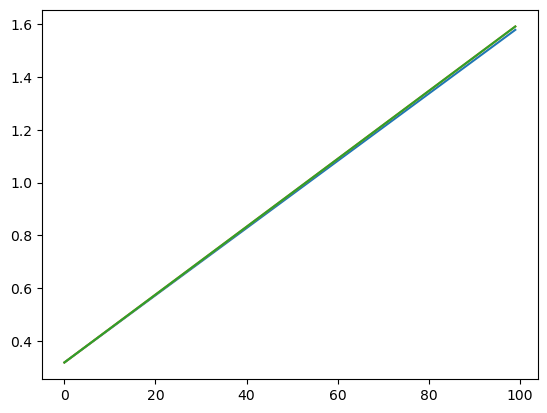

In [31]:
plt.figure()
plt.plot(frequency_domain)
plt.plot(flux_frequencies[0])
plt.plot(flux_frequencies[1])

In [32]:
def plot_meep_vs_theoretical(
            meep_data : np.array, 
            theoretical_data : np.array, 
            sphere_radius : float, 
            frequency_domain
        ): 
    figure = plt.figure(dpi=150)
    yScale = 2 * np.pi * sphere_radius * frequency_domain
    c = ['b', 'g', 'y', 'm', 'c', 'k']
    for index, data in enumerate(meep_data): 
        plt.loglog(yScale, data, c[index] + 'o-', label = 'Meep ' + str(index))
    #plt.loglog(yScale, meep_data[1], 'bo-', label = 'Meep')
    plt.loglog(yScale, theoretical_data, 'ro-', label = 'Theory')
    plt.grid(True, which = "both", ls = '-')
    plt.xlabel(r"Sphere Circumference / Wavelength, $\frac{2\pi r}{\lambda}$")
    plt.ylabel(r"Scattering Efficiency, $\frac{\sigma}{\pi r^{2}}$")
    plt.legend(loc = "upper right")
    plt.title("Mie Scattering of a Lossless Dielectric Sphere")
    plt.tight_layout()
    return figure

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5


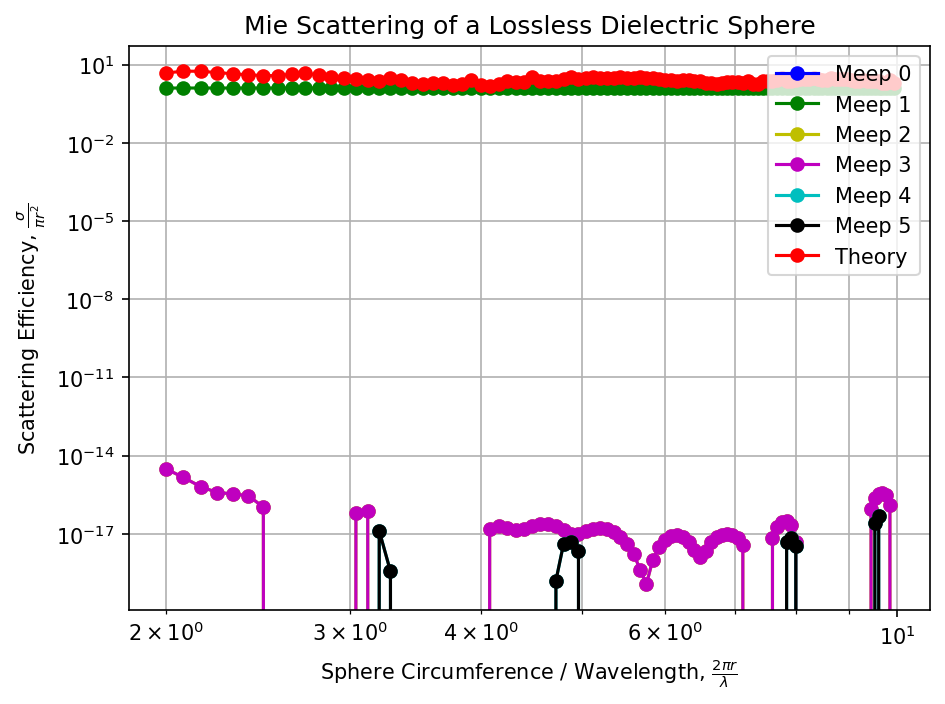

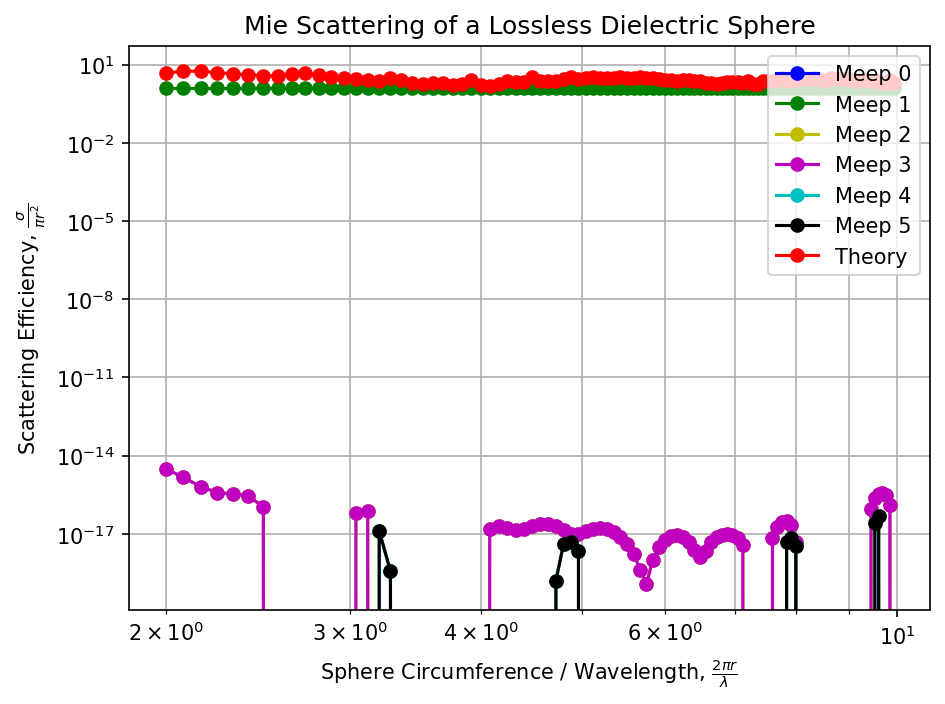

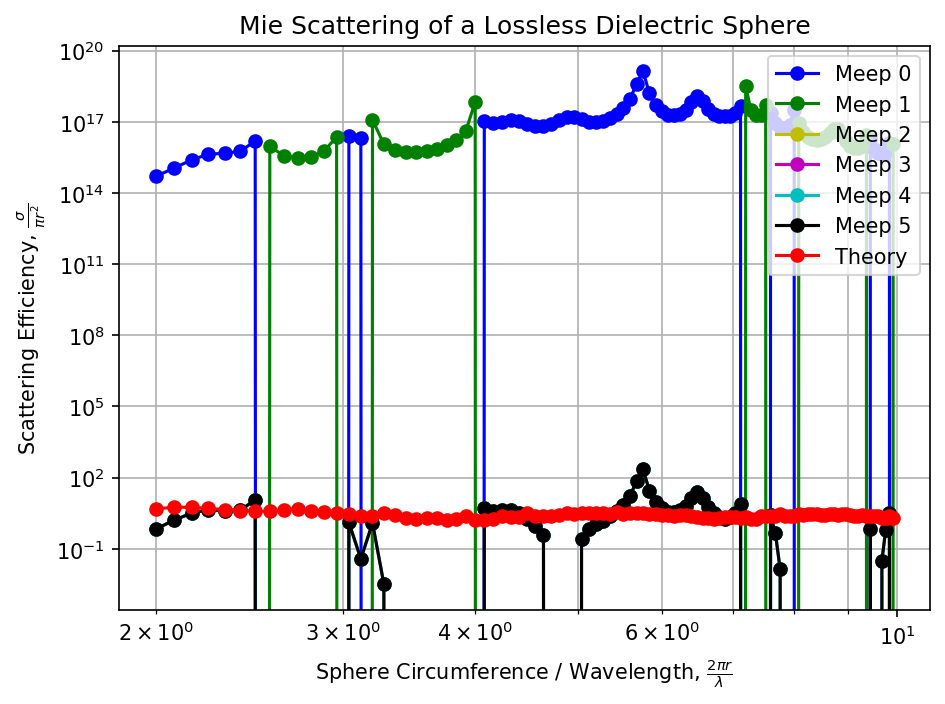

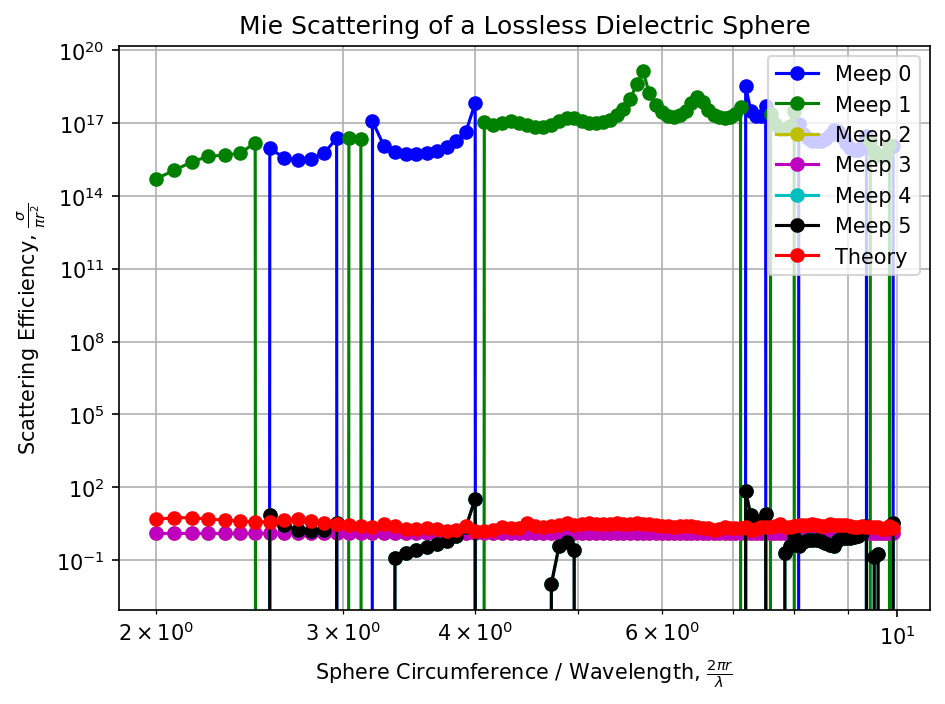

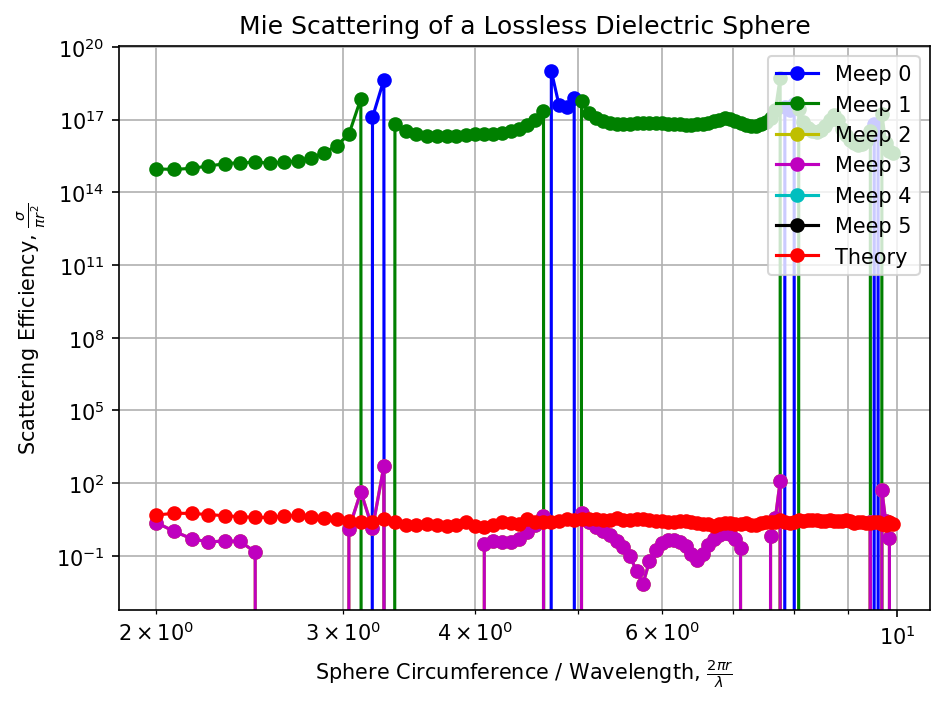

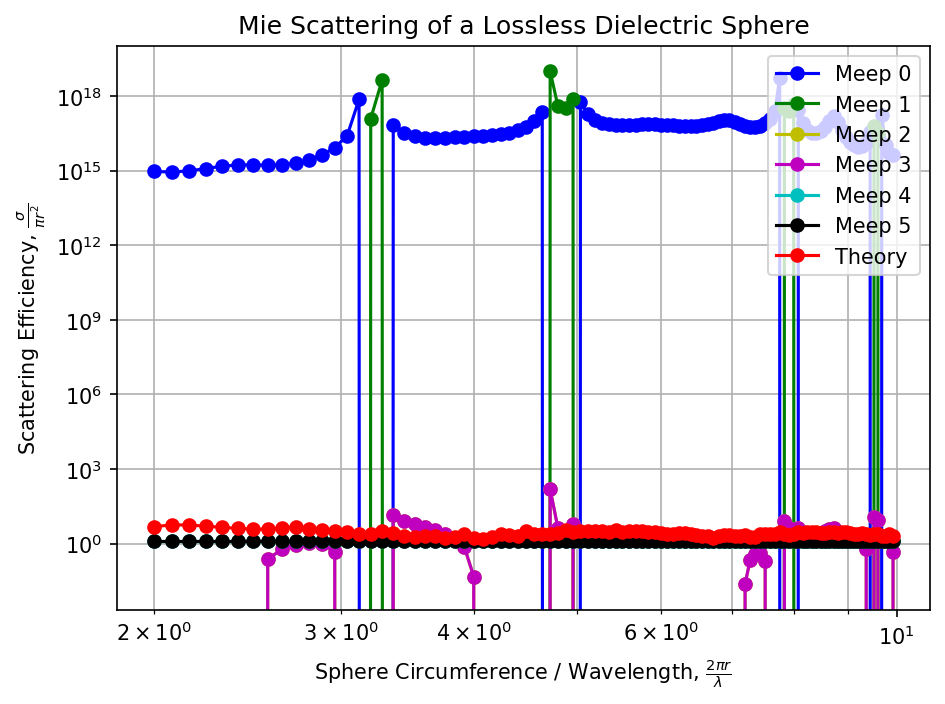

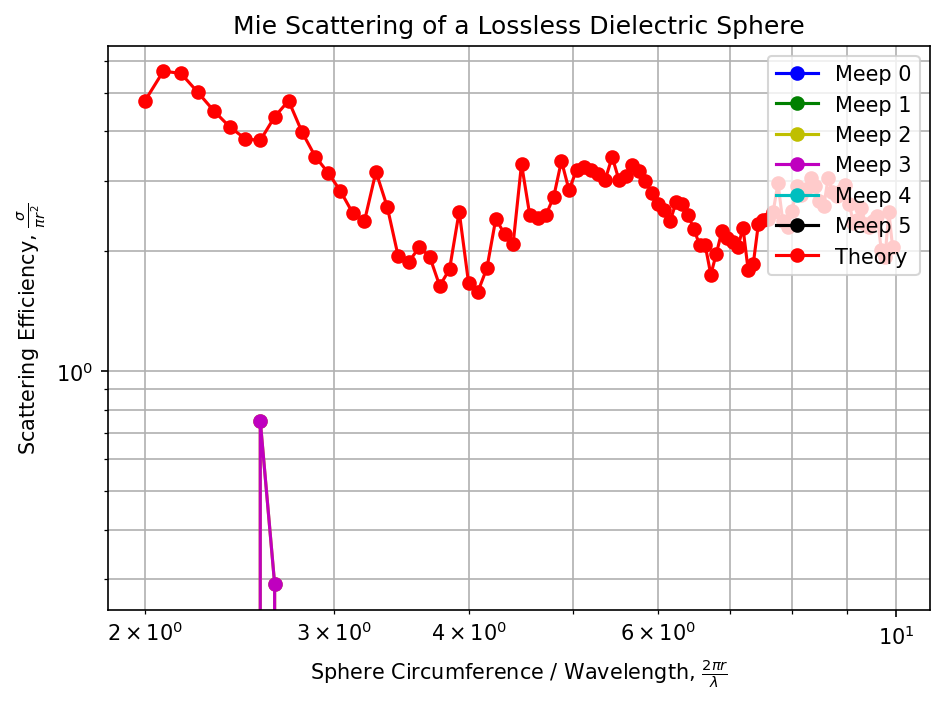

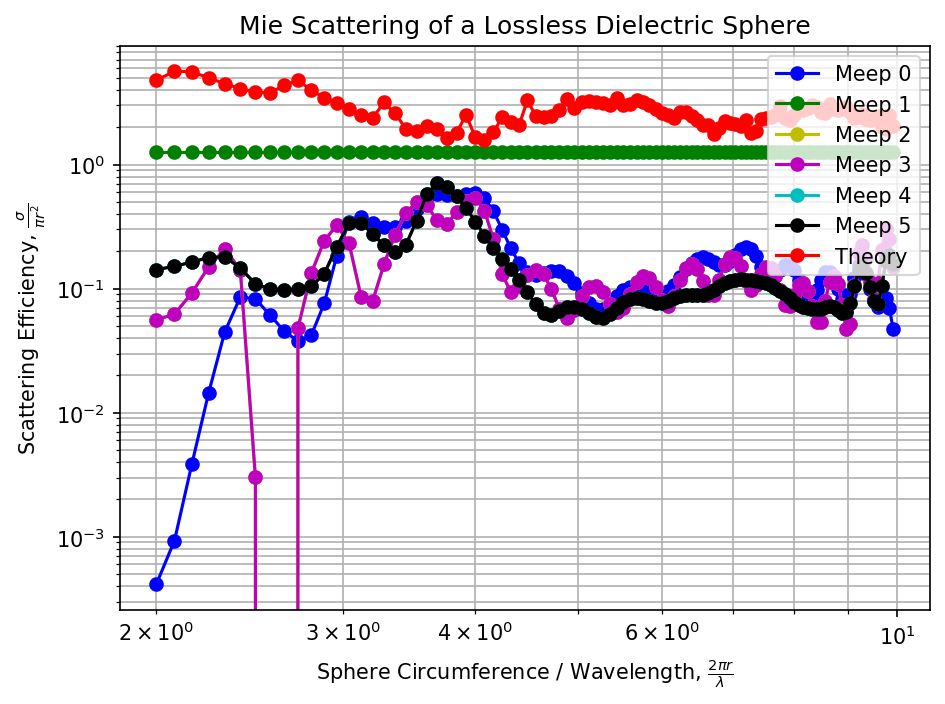

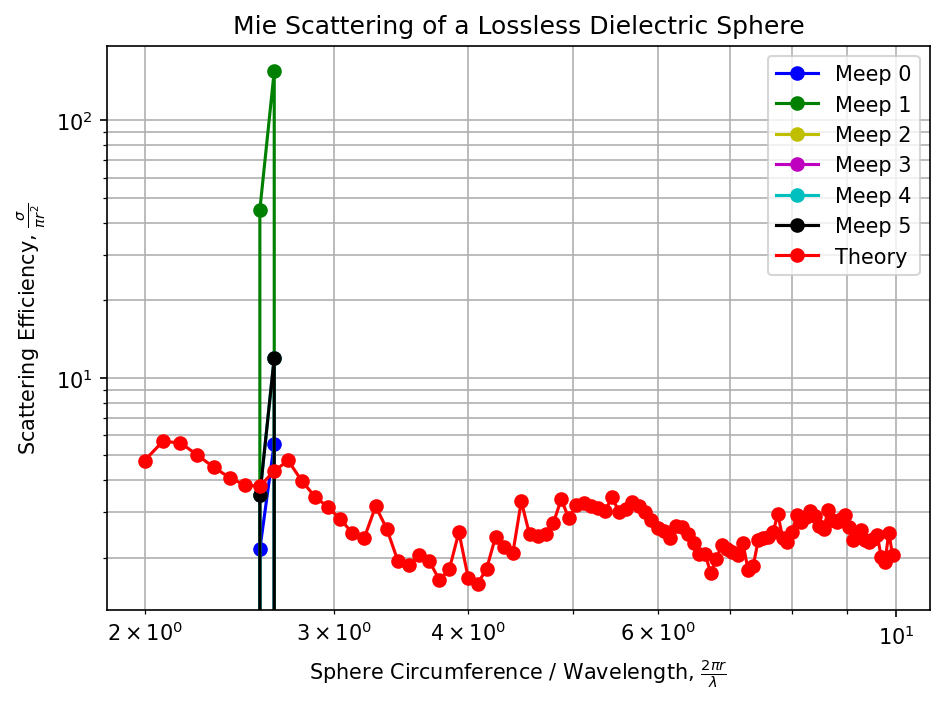

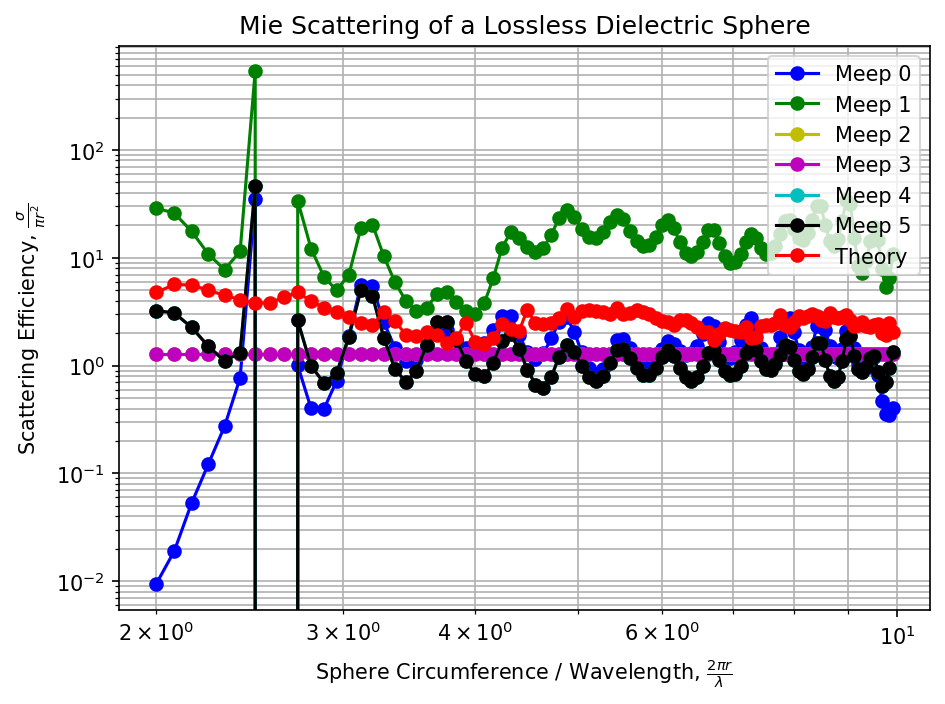

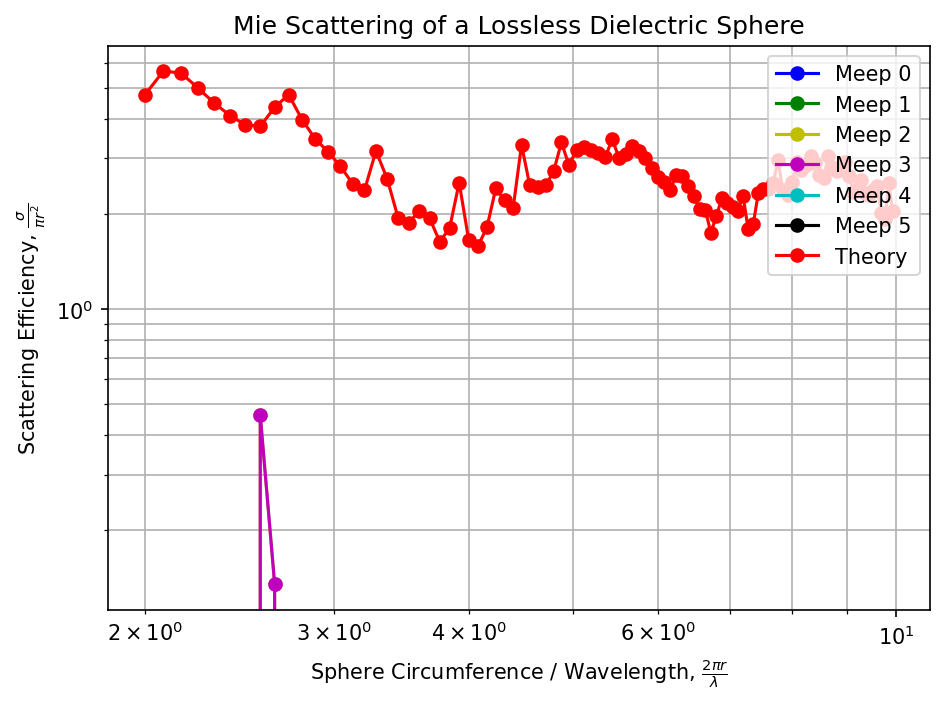

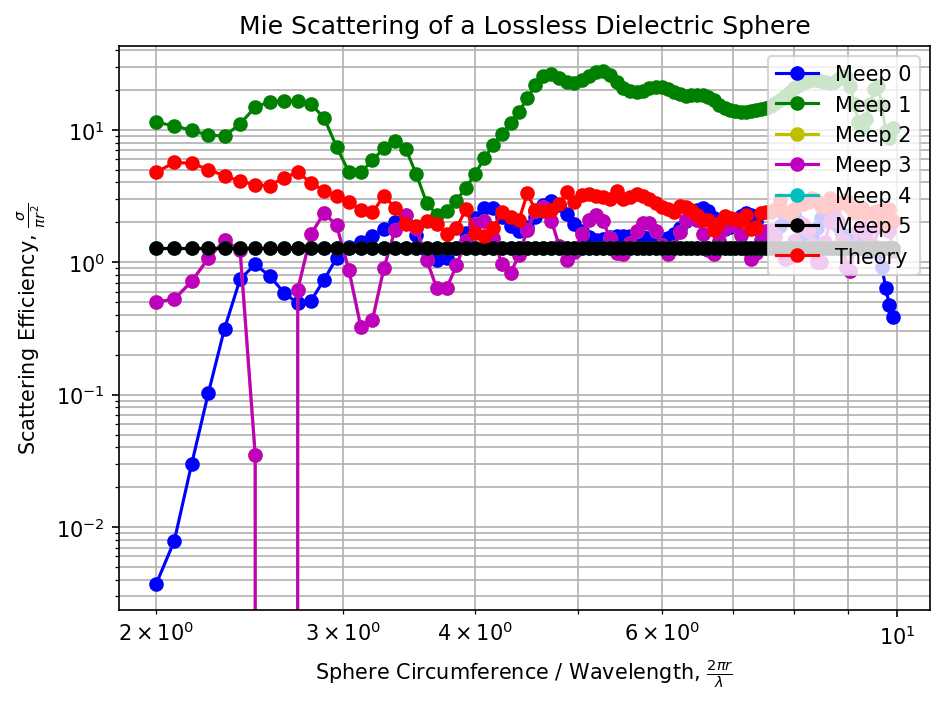

In [33]:
for jj in range(2): 
    for ii in range(6): 
        print(jj, ii)
        meep_data, theoretical_data = theoretical_flux_predict(
                result_fluxes[jj], 
                sphere_radius, 
                sphere_index_of_refraction, 
                result_fluxes[jj][ii], 
                1000, 
                np.array(flux_frequencies[jj])
            )
        figure = plot_meep_vs_theoretical(
                meep_data, 
                theoretical_data, 
                sphere_radius, 
                frequency_domain
            )

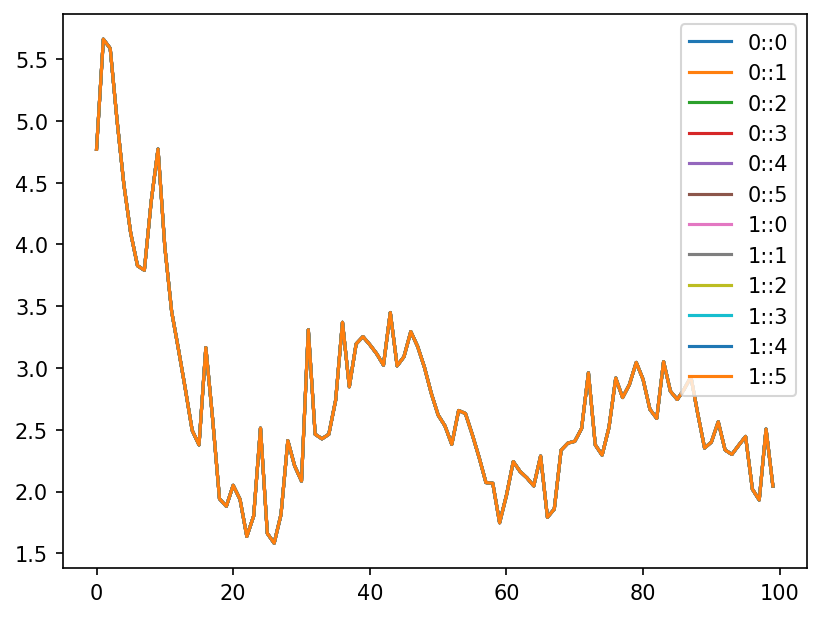

In [34]:
figure = plt.figure(dpi=150)
for simulator_index, simulator_data in enumerate(result_fluxes): 
    for ii in range(len(simulator_data)): 
        meep_data, theoretical_data = theoretical_flux_predict(
                result_fluxes[simulator_index], 
                sphere_radius, 
                sphere_index_of_refraction, 
                simulator_data[ii], 
                1000, 
                np.array(flux_frequencies[simulator_index])
            )
        plt.plot(theoretical_data, label = "{}::{}".format(simulator_index, str(ii)))
plt.legend()
